# **Data Visualization Notebook**

---

## Objectives

*   Answer business requirement 1: 
    * The client requires a study to visually differentiate healthy cherry leaves from those containing powdery mildew.

## Inputs

* inputs/cherry_leaves_dataset/cherry-leaves/train
* inputs/cherry_leaves_dataset/cherry-leaves/test
* inputs/cherry_leaves_dataset/cherry-leaves/validation

## Outputs

* Image shape embeddings pickle file.
* Mean and variability of images per label plot.
* Plot to distinguish the contrast between powdery-mildew-contained and healthy leaves images.
* Generate code that answers business requirement 1 and can be used to build an image montage on the Streamlit dashboard.


## Additional Comments | Insights | Conclusions

N/A


---

# Set Data Directory

---

## Import libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
sns.set_style("white")
from matplotlib.image import imread
import tensorflow as tf
import itertools
import random

2024-01-27 18:55:16.095942: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-27 18:55:16.145328: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-27 18:55:16.147004: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-27 18:55:17.171963: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Set working directory

In [2]:
cwd= os.getcwd()

In [3]:
os.chdir('/workspace/Portfolio_5_Cherry_Leaves_Mildew')
print("You set a new current directory")

You set a new current directory


In [4]:
current_dir = os.getcwd()
current_dir

'/workspace/Portfolio_5_Cherry_Leaves_Mildew'

## Set input directories

Set train, validation and test paths.

In [5]:
my_data_dir = 'inputs/cherry_leaves_dataset/cherry-leaves'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

## Set output directory

In [6]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(current_dir) and version in os.listdir(current_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

Old version is already available create a new version.


### Set label names

In [7]:
# Set the labels
labels = os.listdir(train_path)
print('Label for the images are', labels)

Label for the images are ['healthy', 'powdery_mildew']


---

# Data visualisation of image data

---

## Image shape 

Compute average images size on train set.

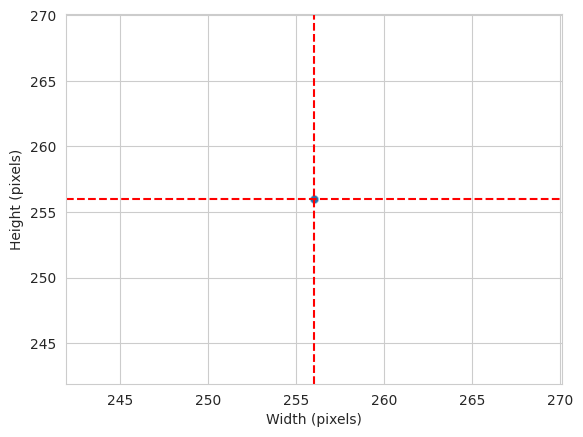

Width average: 256 
Height average: 256


In [8]:
dim1, dim2 = [], []
for label in labels:
    for image_filename in os.listdir(train_path + '/' + label):
        img = imread(train_path + '/' + label + '/' + image_filename)
        d1, d2, colors = img.shape
        dim1.append(d1)  # image height
        dim2.append(d2)  # image width

sns.set_style("whitegrid")
fig, axes = plt.subplots()
sns.scatterplot(x=dim2, y=dim1, alpha=0.2)
axes.set_xlabel("Width (pixels)")
axes.set_ylabel("Height (pixels)")
dim1_mean = int(np.array(dim1).mean())
dim2_mean = int(np.array(dim2).mean())
axes.axvline(x=dim1_mean, color='r', linestyle='--')
axes.axhline(y=dim2_mean, color='r', linestyle='--')
plt.show()
print(f"Width average: {dim2_mean} \nHeight average: {dim1_mean}")

Images size for training the model is the average from all images in the train set.

In [9]:
image_shape = (50, 50)
image_shape

(50, 50)

Save the image shape embeddings

In [10]:
joblib.dump(value=image_shape ,
            filename=f"{file_path}/image_shape.pkl")
print(f"Saved image shape as embeddings: {image_shape}")


Saved image shape as embeddings: (50, 50)


---

## Average and variability of images  per label

---

### Define a function to load and preprocess images using TensorFlow

In [11]:
def load_and_preprocess_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)  # RGB images
    img = tf.image.resize(img, image_shape)
    img = img / 255.0  # Normalize pixel values to [0, 1]
    return img


### Load images and labels using TensorFlow

In [12]:
def load_images_and_labels(data_dir, image_shape, num_images_per_label):
    X, y = [], []
    labels = os.listdir(data_dir)

    for label in labels:
        counter = 0
        for image_filename in os.listdir(os.path.join(data_dir, label)):
            if counter < num_images_per_label:
                image_path = os.path.join(data_dir, label, image_filename)
                img = load_and_preprocess_image(image_path)
                X.append(img)
                y.append(label)
                counter += 1

    X = np.array(X)
    y = np.array(y)

    return X, y

### Load image data

In [13]:
X, y = load_images_and_labels(train_path, image_shape, num_images_per_label=30)
print("Loaded image data. Shapes:", X.shape, y.shape)

Loaded image data. Shapes: (60, 50, 50, 3) (60,)


### Plot and save mean and variability of images per label

In [14]:
def plot_mean_variability_per_labels(X, y, figsize=(12, 5), save_image=False):
    for label_to_display in np.unique(y):
        sns.set_style("white")

        y = y.reshape(-1, 1, 1)
        boolean_mask = np.any(y == label_to_display, axis=1).reshape(-1)
        arr = X[boolean_mask]

        avg_img = np.mean(arr, axis=0)
        std_img = np.std(arr, axis=0)
        print(f"==== Label {label_to_display} ====")
        print(f"Image Shape: {avg_img.shape}")
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
        axes[0].set_title(f"Average image for label {label_to_display}")
        axes[0].imshow(avg_img)
        axes[1].set_title(f"Variability image for label {label_to_display}")
        axes[1].imshow(std_img)

        if save_image:
            plt.savefig(f"{file_path}/avg_var_{label_to_display}.png",
                        bbox_inches='tight', dpi=150)
        else:
            plt.tight_layout()
            plt.show()
            print("\n")

Plotting the images

==== Label healthy ====
Image Shape: (50, 50, 3)
==== Label powdery_mildew ====
Image Shape: (50, 50, 3)


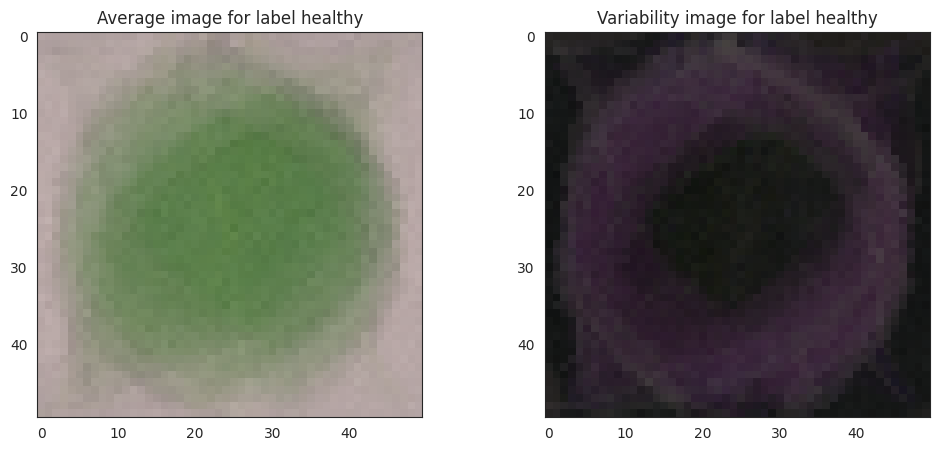

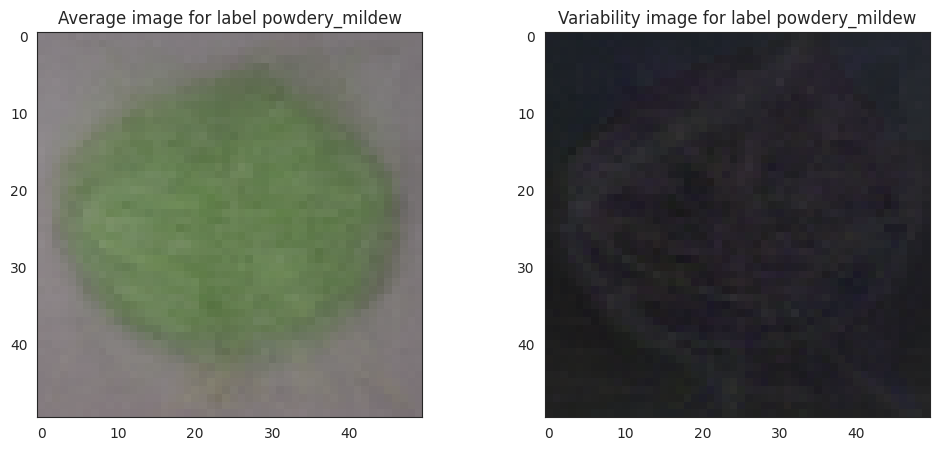

In [15]:
plot_mean_variability_per_labels(X=X, y=y, figsize=(12, 5), save_image=True)


---

## Difference between average mildew-powder-contain and average healthy leaf images

---

In [16]:
from tensorflow import keras
from keras.preprocessing import image

def load_image_as_array(my_data_dir, new_size=(50, 50), n_images_per_label=20):

    X, y = np.array([], dtype='int'), np.array([], dtype='object')
    labels = os.listdir(my_data_dir)

    for label in labels:
        counter = 0
        for image_filename in os.listdir(my_data_dir + '/' + label):
            # n_images_per_label: we set a limit, since it may take too much time
            if counter < n_images_per_label:

                img = image.load_img(
                    my_data_dir + '/' + label + '/' + image_filename, target_size=new_size)
                if image.img_to_array(img).max() > 1:
                    img_resized = image.img_to_array(img) / 255
                else:
                    img_resized = image.img_to_array(img)

                X = np.append(X, img_resized).reshape(-1,
                                                      new_size[0], new_size[1], img_resized.shape[2])
                y = np.append(y, label)
                counter += 1

    return X, y

### Loading image shapes and labels in an array

In [17]:
X, y = load_image_as_array(my_data_dir=train_path,
                           new_size=image_shape,
                           n_images_per_label=30)
print(X.shape, y.shape)


(60, 50, 50, 3) (60,)


---

## Plotting and saving variability of images per label

---

Creating the function

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_mean_variability_per_labels(X, y, figsize=(12, 5), save_image=False, file_path="./"):
    """
    This function plots the average and the variability (standard deviation) of images
    for each unique label in the dataset.

    Parameters:
    - X: numpy array of images.
    - y: numpy array of labels corresponding to images.
    - figsize: tuple, optional, the size of the figure (width, height in inches).
    - save_image: bool, optional, if True, saves the plots as images in the specified file path.
    """
    unique_labels = np.unique(y)

    for label_to_display in unique_labels:
        sns.set_style("white")

        # Filter images by label
        images_for_label = X[y == label_to_display]

        # Calculate the average and standard deviation
        avg_img = np.mean(images_for_label, axis=0)
        std_img = np.std(images_for_label, axis=0)

        # Plotting
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
        axes[0].set_title(f"Average Image for Label {label_to_display}")
        axes[0].imshow(avg_img, cmap='hot')  # 'hot' colormap for the average image

        axes[1].set_title(f"Variability Image for Label {label_to_display}")
        axes[1].imshow(std_img, cmap='hot')  # 'viridis' colormap to represent variability

        # Optionally save the figure
        if save_image:
            plt.savefig(f"{file_path}avg_var_label_{label_to_display}.png", bbox_inches='tight', dpi=150)
        else:
            plt.show()

   



Plotting the images

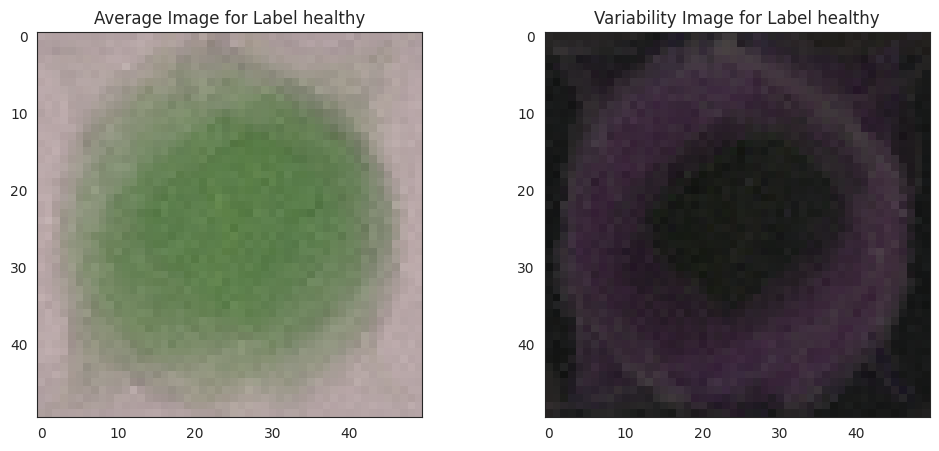

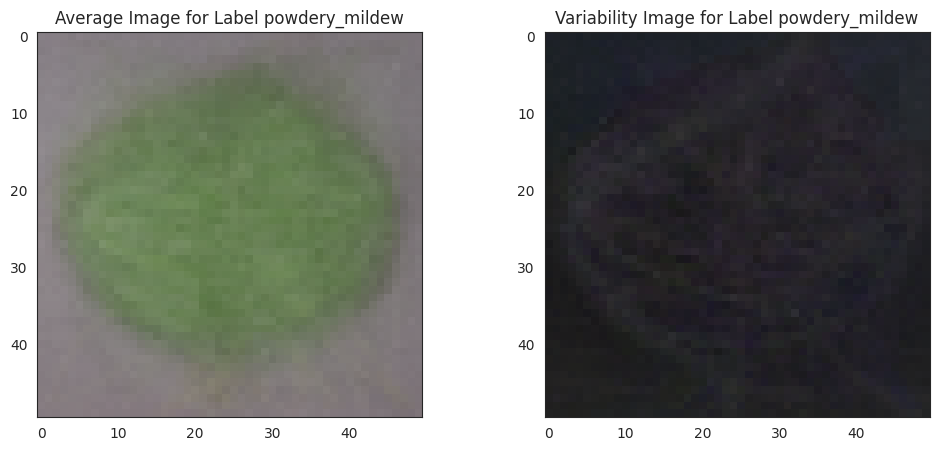

In [19]:
plot_mean_variability_per_labels(X=X, y=y, figsize=(12, 5), save_image=True)

---

## Checking the difference between average healthy and powdery_mildew images


---

In [20]:
def subset_image_label(X, y, label_to_display):
    y = y.reshape(-1, 1, 1)
    boolean_mask = np.any(y == label_to_display, axis=1).reshape(-1)
    df = X[boolean_mask]
    return df


def diff_bet_avg_image_labels_data_as_array(X, y, label_1, label_2, figsize=(20, 5), save_image=False):
    """
    Checks if the labels exist in the set of unique labels
    Calculates the mean and difference for label1 and label2
    Plots a chart and saves it if save_image=True
    """
    sns.set_style("white")

    if (label_1 not in np.unique(y)) or (label_2 not in np.unique(y)):
        print(
            f"Either label {label} or label {label_2}, are not in {np.unique(y)} ")
        return

    # calculate mean from label1
    images_label = subset_image_label(X, y, label_1)
    label1_avg = np.mean(images_label, axis=0)

    # calculate mean from label2
    images_label = subset_image_label(X, y, label_2)
    label2_avg = np.mean(images_label, axis=0)

    # calculate difference and plot difference, avg label1 and avg label2
    difference_mean = label1_avg - label2_avg
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=figsize)
    axes[0].imshow(label1_avg, cmap='hot')
    axes[0].set_title(f'Average {label_1}')
    axes[1].imshow(label2_avg, cmap='hot')
    axes[1].set_title(f'Average {label_2}')
    axes[2].imshow(difference_mean, cmap='hot')
    axes[2].set_title(f'Difference image: Avg {label_1} & {label_2}')
    if save_image:
        plt.savefig(f"{file_path}/avg_diff.png", bbox_inches='tight', dpi=150)
    else:
        plt.tight_layout()
        plt.show()

Plotting and saving the images



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


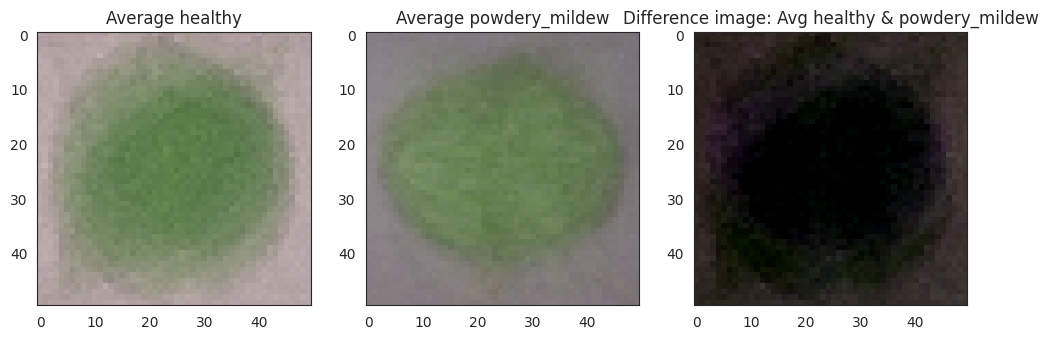

In [21]:
diff_bet_avg_image_labels_data_as_array(X=X, y=y,
                                        label_1='healthy', label_2='powdery_mildew',
                                        figsize=(12, 10),
                                        save_image=True
                                        )

---

## Image Montage

---

Define a function to create an image montage using TensorFlow

In [22]:
import itertools
import random
sns.set_style("white")


def image_montage(dir_path, label_to_display, nrows, ncols, figsize=(15, 10)):
    """
    if the label exists in the directory
    check if your montage space is greater than the subset size
    create a list of axes indices based on nrows and ncols
    create a Figure and display images
    in this loop, load and plot the given image
    """

    labels = os.listdir(dir_path)

    # subset the class you are interested to display
    if label_to_display in labels:

        # checks if your montage space is greater than the subset size
        images_list = os.listdir(dir_path + '/' + label_to_display)
        if nrows * ncols < len(images_list):
            img_idx = random.sample(images_list, nrows * ncols)
        else:
            print(
                f"Decrease nrows or ncols to create your montage. \n"
                f"There are {len(images_list)} in your subset. "
                f"You requested a montage with {nrows * ncols} spaces")
            return

        # create a list of axes indices based on nrows and ncols
        list_rows = range(0, nrows)
        list_cols = range(0, ncols)
        plot_idx = list(itertools.product(list_rows, list_cols))

        # create a Figure and display images
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
        for x in range(0, nrows*ncols):
            img = imread(dir_path + '/' + label_to_display + '/' + img_idx[x])
            img_shape = img.shape
            axes[plot_idx[x][0], plot_idx[x][1]].imshow(img)
            axes[plot_idx[x][0], plot_idx[x][1]].set_title(
                f"Width {img_shape[1]}px x Height {img_shape[0]}px")
            axes[plot_idx[x][0], plot_idx[x][1]].set_xticks([])
            axes[plot_idx[x][0], plot_idx[x][1]].set_yticks([])
        plt.tight_layout()
        plt.show()

    else:
        print("The label you selected doesn't exist.")
        print(f"The existing options are: {labels}")

Run Montage in all labels

healthy


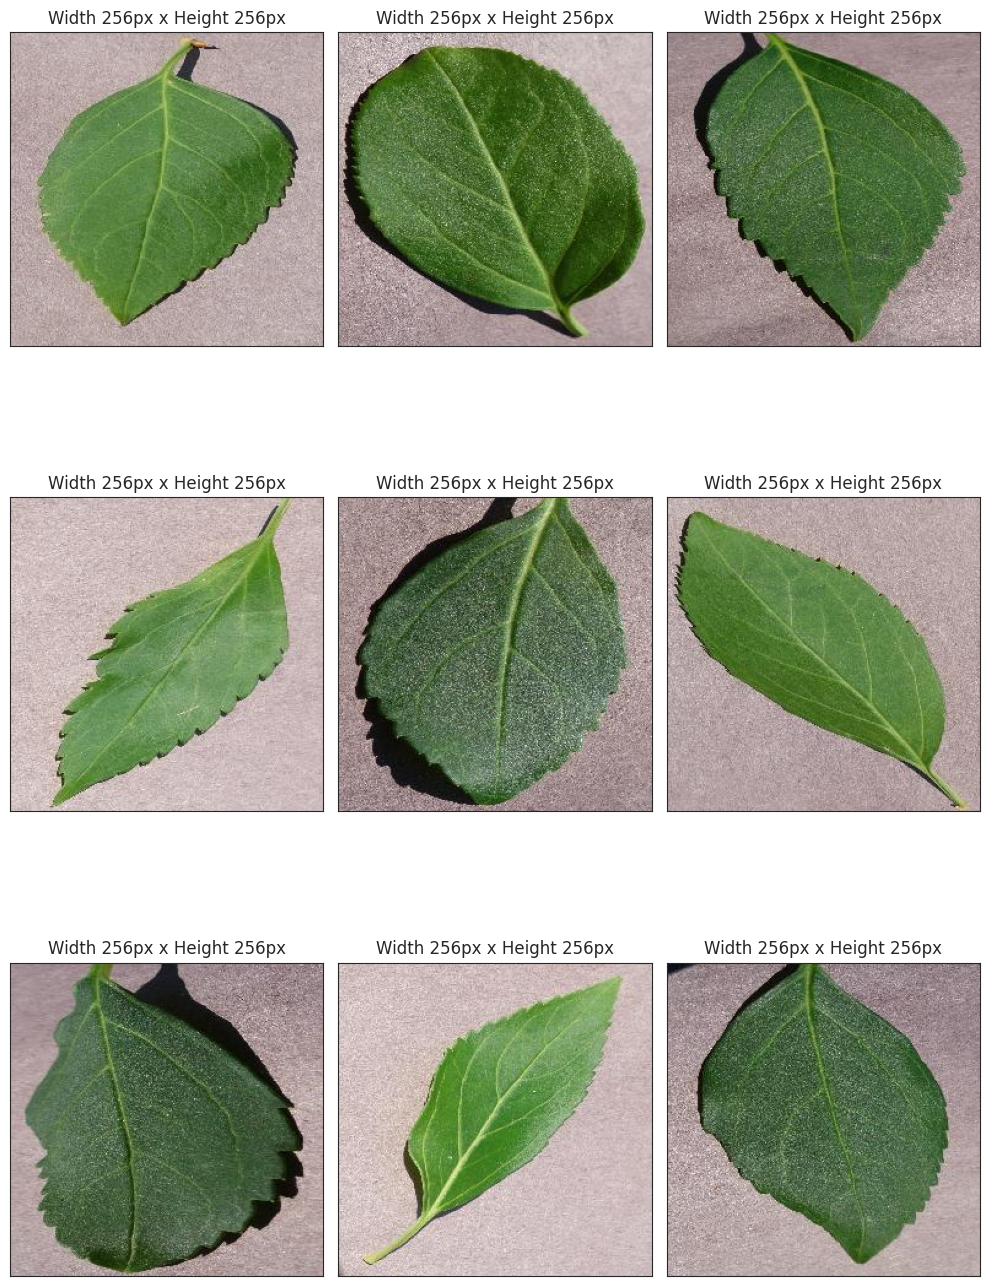



powdery_mildew


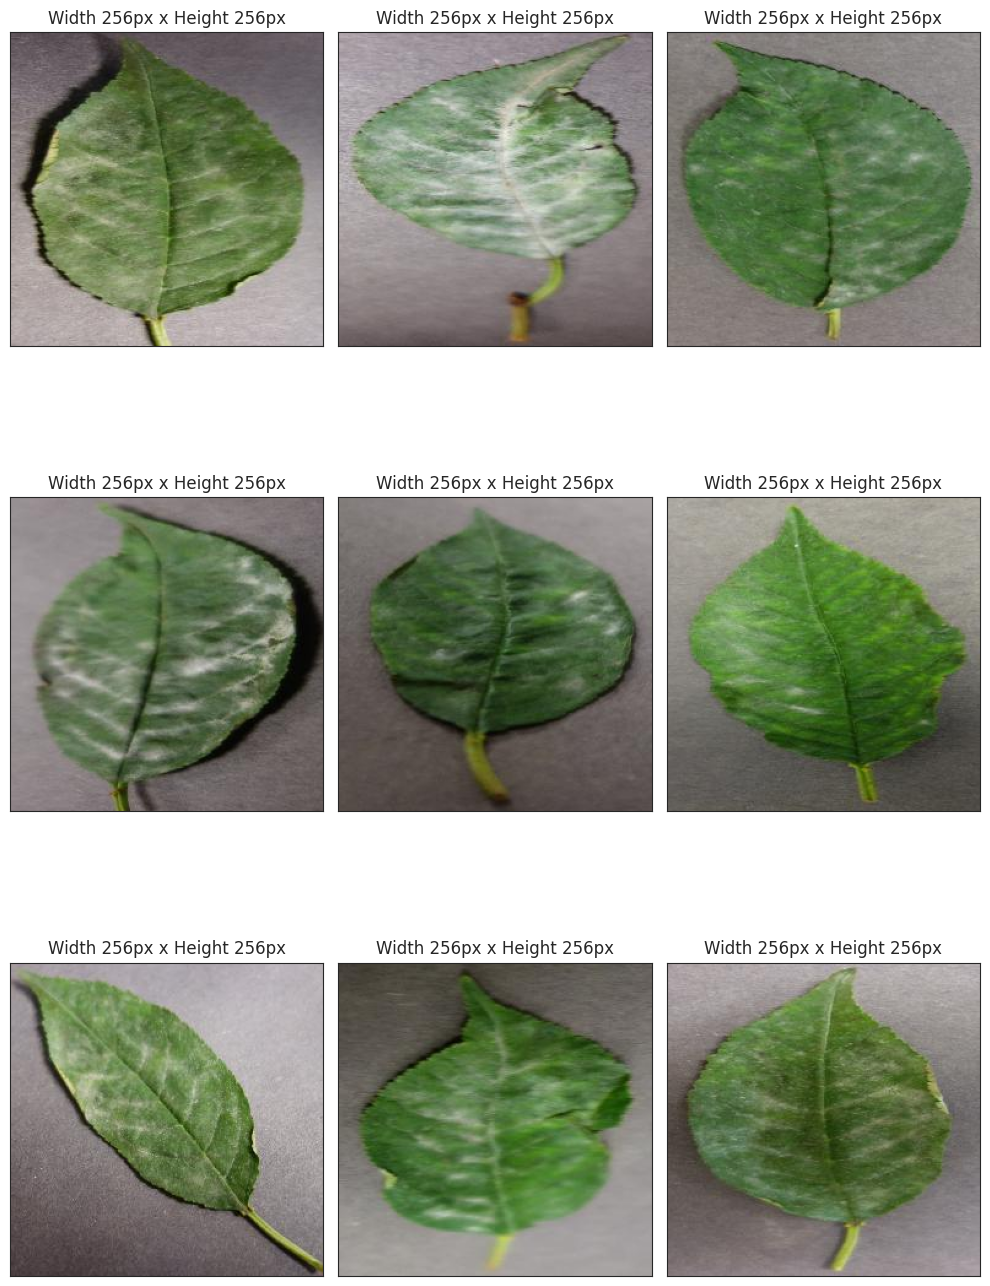

In [23]:
for label in labels:
    print(label)
    image_montage(dir_path=train_path,
                  label_to_display=label,
                  nrows=3, ncols=3,
                  figsize=(10, 15)
                  )
    print("\n")

---

# Conclusions 
- Healthy leaves typically appear darker in average images compared to powdery mildew-affected leaves.
- The difference in average brightness between the two sets of images highlights the contrast between healthy and powdery mildew-affected leaves.
- The presence of affected leaves is clearly visible in the image montage.